# Dummy example to test CVAE

## DATASET GENERATION

In [1]:
# import numpy as np

# # generate input x ~ Uniform(-3π, 3π)
# N = 10000 # number of samples to generate
# x = np.random.uniform(-4 * np.pi, 4 * np.pi, size=(N, 1))  # shape [N, 1]

# # generate output y = sin(x) + noise
# noise = np.random.normal(0, 0.001, size=(N, 1))
# y = np.sin(x) + noise  # shape [N, 1]

# # save as dummy dataset with matching naming convention
# np.savez("data/dummy_sine.npz", S=x, P=y)

# # 10k structure values and 10k noisy sine values
# print("Saved dummy dataset with shapes:", x.shape, y.shape)

In [2]:
# import numpy as np

# # load original dataset
# data = np.load("data/dummy_sine.npz")
# S = data['S']
# P = data['P']

# # normalize to zero mean and unit std
# S_mean, S_std = S.mean(), S.std()
# P_mean, P_std = P.mean(), P.std()

# S_norm = (S - S_mean) / S_std
# P_norm = (P - P_mean) / P_std

# # save normalized dataset
# np.savez(
#     "data/dummy_sine_normalized.npz",
#     S=S_norm, P=P_norm,
#     S_mean=S_mean, S_std=S_std,
#     P_mean=P_mean, P_std=P_std
# )

# print("Saved normalized dataset with shapes:", S_norm.shape, P_norm.shape)

## INFERENCE

In [3]:
import torch
import importlib
from config import *

device = torch.device("cpu")

# === choose trial number to load ===
trial = 15  # CHANGE THIS
decoder_path = f'models/checkpoints/iteration_{trial}/decoder_{trial}.pt'

# === define dimensions used in old trials ===
latent_dim_old = 3 # CHANGE THIS
p_dim_old = 1
s_dim_old = 1

# === automatically select correct decoder and initialize it ===
if trial < TRIAL:
    Decoder = importlib.import_module("models.decoder_old").Decoder
    decoder = Decoder(s_dim_old, p_dim_old, latent_dim_old).to(device)
    latent_dim = latent_dim_old
    p_dim = p_dim_old
else:
    Decoder = importlib.import_module("models.decoder").Decoder
    decoder = Decoder(S_DIM, P_DIM, LATENT_DIM).to(device)
    latent_dim = LATENT_DIM
    p_dim = P_DIM

# === load weights ===
decoder.load_state_dict(torch.load(decoder_path, map_location=device))
decoder.eval()


/var/folders/9z/9fdpt4_148s8zzl9h0tr9dgw0000gn/T/ipykernel_85231/3840484528.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  decoder.load_state_dict(torch.load(decoder_p

Decoder(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (relu1): Tanh()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): Tanh()
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (relu3): Tanh()
  (fc4): Linear(in_features=32, out_features=1, bias=True)
)

In [4]:
# define the inference function
def get_S_hats(P_val, num_samples=100):
    """
    Sample diverse structure values S-hat given a target property P.
    """
    # wrap scalar P_val into a tensor (repeats the same P_val num_samples times so you get shape [num_samples, 1])
    P_tensor = torch.tensor([[P_val]], dtype=torch.float32).repeat(num_samples, 1).to(device)
    # sample num_samples vectors z ~ N(0, I) from the standard normal latent space
    z_samples = torch.randn((num_samples, LATENT_DIM)).to(device) 
    # use trained decoder to get predicted S-hat values 
    with torch.no_grad(): # turn off gradient tracking to save memory
        S_hats = decoder(z_samples, P_tensor)

    return S_hats.cpu().numpy()

## VISUALIZATION

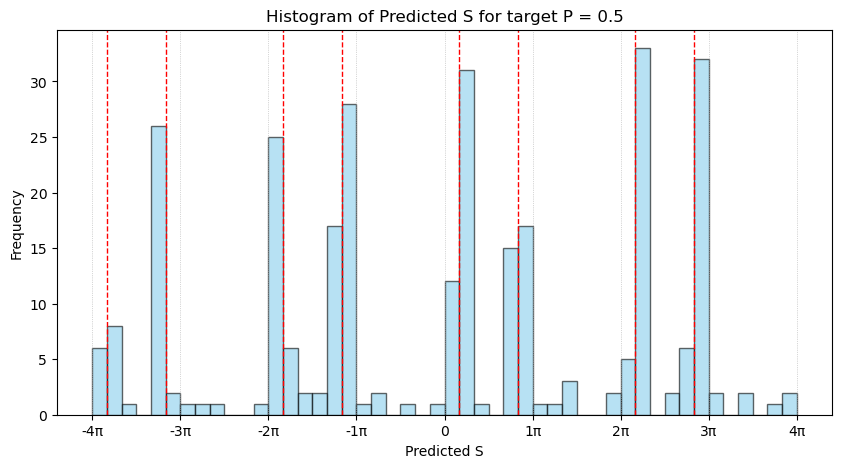

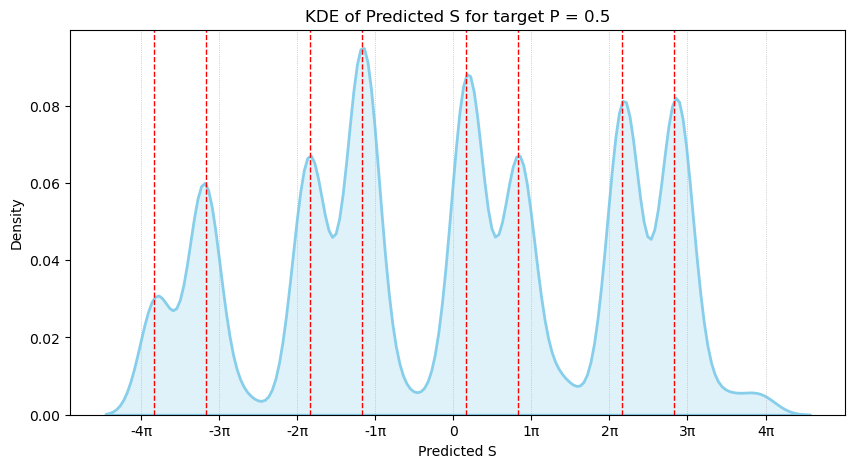

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# === define get_S_hats with flexible latent_dim and device ===
def get_S_hats(P_val, num_samples=300):
    """
    Sample diverse structure values S-hat given a target property P.
    """
    P_tensor = torch.tensor([[P_val]], dtype=torch.float32).repeat(num_samples, 1).to(device)
    z_samples = torch.randn((num_samples, latent_dim)).to(device)

    with torch.no_grad():
        S_hats = decoder(z_samples, P_tensor)
    return S_hats.cpu().numpy().flatten()

# === target property to invert ===
P = 0.5

# === get predicted S values ===
S_hats = get_S_hats(P)

# data = np.load("data/dummy_sine_normalized.npz") # denormalize if needed
# S_mean = data["S_mean"]
# S_std = data["S_std"]
# S_hats = S_hats * S_std + S_mean

# === define true sine roots for sin(S) = P ===
k_vals = np.arange(-3, 4)
roots = [k * 2 * np.pi + np.pi/6 for k in k_vals] + [k * 2 * np.pi + 5*np.pi/6 for k in k_vals]
roots = [r for r in roots if -4*np.pi <= r <= 4*np.pi]

# === plot histogram ===
plt.figure(figsize=(10, 5))
bin_edges = np.arange(-4*np.pi, 4*np.pi + np.pi/6, np.pi/6)
plt.hist(S_hats, bins=bin_edges, color='skyblue', edgecolor='black', alpha=0.6)
for root in roots:
    plt.axvline(root, color='red', linestyle='--', linewidth=1)
xticks = np.arange(-4*np.pi, 4.5*np.pi, np.pi)
xtick_labels = [f"{int(x/np.pi)}π" if x != 0 else "0" for x in xticks]
plt.xticks(xticks, xtick_labels)
plt.title(f"Histogram of Predicted S for target P = {P}")
plt.xlabel("Predicted S")
plt.ylabel("Frequency")
plt.grid(True, axis='x', linestyle=':', linewidth=0.5)
plt.show()

# === plot KDE ===
plt.figure(figsize=(10, 5))
sns.kdeplot(S_hats, bw_adjust=0.3, fill=True, color='skyblue', linewidth=2)
for root in roots:
    plt.axvline(root, color='red', linestyle='--', linewidth=1)
plt.xticks(xticks, xtick_labels)
plt.title(f"KDE of Predicted S for target P = {P}")
plt.xlabel("Predicted S")
plt.ylabel("Density")
plt.grid(True, axis='x', linestyle=':', linewidth=0.5)
plt.show()


## STATS

In [15]:
import numpy as np
from scipy.stats import gaussian_kde, entropy
from sklearn.metrics import mean_squared_error

# === define true roots of sin(S) = P ===
k_vals = np.arange(-6, 7)
true_roots = [k * 2 * np.pi + np.pi/6 for k in k_vals] + [k * 2 * np.pi + 5*np.pi/6 for k in k_vals]
true_roots = sorted([r for r in true_roots if -4*np.pi <= r <= 4*np.pi])  # only count visible (plotted) roots

# === compute top-5 predicted peaks ===
bin_edges = np.arange(-6*np.pi, 6*np.pi + np.pi/6, np.pi/6)
counts, bins = np.histogram(S_hats, bins=bin_edges)
bin_centers = (bins[:-1] + bins[1:]) / 2
top_indices = np.argsort(counts)[-5:]  # indices of top 5 highest bins
top_preds = np.sort(bin_centers[top_indices])

# === evaluation ===
print(f"Evaluation for target P = {P}")
S_hats = np.array(S_hats).flatten()
threshold = 0.3  # tolerance for matching

# 1. root recall
recalled_roots = sum(np.any(np.abs(S_hats - root) < threshold) for root in true_roots)
recall = recalled_roots / len(true_roots)
print(f"✅ Root Recall: {recall:.2f} ({recalled_roots}/{len(true_roots)})")

# 2. root precision (top predictions)
precision_hits = 0
closest_true = []
for pred in top_preds:
    closest = min(true_roots, key=lambda r: abs(pred - r))
    closest_true.append(closest)
    if abs(pred - closest) < threshold:
        precision_hits += 1
precision = precision_hits / len(top_preds)
print(f"✅ Root Precision (Top Predictions): {precision:.2f} ({precision_hits}/{len(top_preds)})")

# 3. top-5 MSE
mse = mean_squared_error(closest_true, top_preds)
print(f"✅ Top-5 MSE: {mse:.6f}")

# 4. KL divergence (KDE-based)
kde_pred = gaussian_kde(S_hats)
kde_true = gaussian_kde(true_roots)
grid = np.linspace(-6*np.pi, 6*np.pi, 1000)
p_pred = kde_pred(grid) + 1e-8  # avoid log(0)
p_true = kde_true(grid) + 1e-8
kl = entropy(p_true, p_pred)
print(f"✅ KL Divergence (true || predicted): {kl:.4f}")

# 5. spread (standard deviation)
spread = np.std(S_hats)
print(f"✅ Prediction Spread (std dev): {spread:.3f}")

# 6. mass near true roots
mass_near_roots = sum(np.sum(np.abs(S_hats - root) < threshold) for root in true_roots)
mass_frac = mass_near_roots / len(S_hats)
print(f"✅ Mass near true roots: {mass_frac:.2%}")


Evaluation for target P = 0.5
✅ Root Recall: 1.00 (8/8)
✅ Root Precision (Top Predictions): 1.00 (5/5)
✅ Top-5 MSE: 0.068539
✅ KL Divergence (true || predicted): 0.1530
✅ Prediction Spread (std dev): 6.640
✅ Mass near true roots: 82.00%
